# Introduction

A quick explanation of Pandas, Matplotlib and Sklearn, specially including their histories. (less than a minute)
https://medium.com/personal-project/numpy-pandas-and-scikit-learn-explained-e7336baecedc

## Pandas
https://en.wikipedia.org/wiki/Pandas_(software)#History
Developer Wes McKinney started working on pandas in 2008 while at AQR Capital Management out of the need for a high performance, flexible tool to perform quantitative analysis on financial data. Before leaving AQR he was able to convince management to allow him to open source the library.
Another AQR employee, Chang She, joined the effort in 2012 as the second major contributor to the library.
In 2015, pandas signed on as a fiscally sponsored project of NumFOCUS, a 501(c)(3) nonprofit charity in the United States.[10]

Intro: https://www.youtube.com/watch?v=XDAnFZqJDvI

## Matplotlib
https://en.wikipedia.org/wiki/Matplotlib
Matplotlib was originally written by John D. Hunter, since then it has an active development community,[4] and is distributed under a BSD-style license. Michael Droettboom was nominated as matplotlib's lead developer shortly before John Hunter's death in August 2012,[5] and further joined by Thomas Caswell.[6][7]


## Sklearn
https://en.wikipedia.org/wiki/Scikit-learn
The scikit-learn project started as scikits.learn, a Google Summer of Code project by David Cournapeau. Its name stems from the notion that it is a "SciKit" (SciPy Toolkit), a separately-developed and distributed third-party extension to SciPy.[4] The original codebase was later rewritten by other developers. In 2010 Fabian Pedregosa, Gael Varoquaux, Alexandre Gramfort and Vincent Michel, all from the French Institute for Research in Computer Science and Automation in Rocquencourt, France, took leadership of the project and made the first public release on February the 1st 2010.[5] Of the various scikits, scikit-learn as well as scikit-image were described as "well-maintained and popular" in November 2012.[6] Scikit-learn is one of the most popular machine learning libraries on GitHub.[7].

Intro: https://www.youtube.com/watch?v=rvVkVsG49uU

## Loading libraries

In [50]:
# General usage
import math
import numpy as np
import pandas as pd

# Reporting
from pandas_profiling import ProfileReport

# Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, confusion_matrix, precision_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# https://dateutil.readthedocs.io/en/stable/relativedelta.html
from datetime import datetime
from dateutil.relativedelta import relativedelta, MO

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Importing the database: RBA_KYC_Accounts_ALL_Ids.xlsx
Read source data from the Excel files

In [2]:
# df = pd.read_excel('raw/RBA_KYC_Accounts_ALL_Ids.xlsx')
df_metadata_profession = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Profession', keep_default_na=False)
df_metadata_ledgers = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Ledgers', keep_default_na=False)
df_metadata_cus_class = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Cus_Class', keep_default_na=False)
df_metadata_eco_sec = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='ECO_SEC', keep_default_na=False)
df_metadata_legal_sta_code = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Legal_STA_Code', keep_default_na=False)
df_metadata_countries = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='COUNTRIES', keep_default_na=False)
df_metadata_currencies = pd.read_excel('raw/RBA Metadata.xlsx', sheet_name='Currencies', keep_default_na=False)

For speed, we store the Excel file in a Pickle.
https://stackoverflow.com/a/17098736/3780957

In [3]:
# df.to_pickle('storage\RBA_KYC_Accounts_ALL_Ids.pkl')
df = pd.read_pickle('storage/RBA_KYC_Accounts_ALL_Ids.pkl')

In [4]:
# Columns allocation

print('\n'*2)
print('Alek')
print(df.columns[0:9])
print('\n'*2)
print('Addison')
print(df.columns[9:18])
print('\n'*2)
print('Esperanza')
print(df.columns[18:27])
print('\n'*2)
print('Aziz')
print(df.columns[27:36])
print('\n'*2)
print('Bretti')
print(df.columns[36:])




Alek
Index(['org_code', 'branchCode', 'customerId', 'fullaccount', 'customerType',
       'creationDate', 'onboarding', 'residentStatus', 'residentCountry'],
      dtype='object')



Addison
Index(['nationalityOriginal', 'extraNationality', 'dateOfBirth', 'age_in_year',
       'birthCountry', 'birthPlace', 'profession', 'companyType', 'giinCode'],
      dtype='object')



Esperanza
Index(['lastUpdate', 'status', 'ledgerCode', 'accountCurrency', 'jointAccount',
       'IsBlackListed', 'CUS_CLASS', 'ECO_SEC', 'TYPE_OF_DEP'],
      dtype='object')



Aziz
Index(['GENDER', 'LEGAL_STA_CODE', 'legal_Stat_desc', 'avg_last_10_days',
       'avg_last_30_days', 'avg_last_90_days', 'number_of_cash_dep_90_days',
       'avg_cash_deposit_90_days', 'number_of_deposit_90_days'],
      dtype='object')



Bretti
Index(['avg_of_dep_90_days', 'number_of_cash_wd_90_days',
       'avg_of_cash_wd_90_days', 'number_of_wd_90_days', 'avg_of_wd_90_days',
       'date_of_assessment', 'rbaGradeAbrv', 'rba_grad

Merge data frames to have the complete country name.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html#pandas.merge

In [5]:
def merge_metatada(metadata, name_left, df):
    metadata.columns = metadata.columns.str.lower()
    name_col = f'{name_left}_DescriptionENG'
    metadata[name_col] =metadata['descriptioneng']
    df = df.merge(metadata[['value', name_col]], left_on=name_left, right_on='value', how='left')
    df.drop('value', axis=1, inplace=True)
    return df

df = merge_metatada(df_metadata_profession, 'profession', df)
df = merge_metatada(df_metadata_ledgers, 'ledgerCode', df)
df = merge_metatada(df_metadata_cus_class, 'CUS_CLASS', df)
df = merge_metatada(df_metadata_eco_sec, 'ECO_SEC', df)
df = merge_metatada(df_metadata_legal_sta_code, 'LEGAL_STA_CODE', df)
df = merge_metatada(df_metadata_currencies, 'accountCurrency', df)

In [6]:
for x in ['residentCountry', 'nationalityOriginal', 'extraNationality']:
    country_x = f'{x}_CountryName'
    df_metadata_countries[country_x] = df_metadata_countries['DescriptionENG']
    df = df.merge(df_metadata_countries[['value', country_x]], left_on=x, right_on='value', how='left')
    df.drop('value', axis=1, inplace=True)

In [7]:
df

,org_code,branchCode,customerId,fullaccount,customerType,creationDate,onboarding,residentStatus,residentCountry,nationalityOriginal,...,rbaValue,profession_DescriptionENG,ledgerCode_DescriptionENG,CUS_CLASS_DescriptionENG,ECO_SEC_DescriptionENG,LEGAL_STA_CODE_DescriptionENG,accountCurrency_DescriptionENG,residentCountry_CountryName,nationalityOriginal_CountryName,extraNationality_CountryName
0,1,201,20100400550000072,020100400550015817000,2,2015-04-05,N,1,JO,JO,...,13.20,NaN,Subscribers of the bond loan of Bandar Trading...,Commercial Record,Other commercial activities,Governmental institutions outside the budget,Jordanian Dinar,Jordan,Jordan,NaN
1,1,202,20200207860000638,020200207860011330000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,Advances of employees,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
2,1,202,20200207860000638,020200207860011389002,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
3,1,202,20200207860000638,020200207860010060000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,Classic savings,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
4,1,202,20200207860000638,020200207860010010000,1,2013-09-17,N,1,JO,JO,...,16.93,Banker,my neighbour,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225008,1,404,40400811920003507,040400811920010020000,1,2017-10-22,N,1,JO,JO,...,16.53,NaN,Save me golden,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
225009,1,202,20200577640010547,020200577640015300042,2,2004-07-27,N,1,JO,JO,...,57.60,NaN,NaN,Commercial Record,Trade cars and spare parts,Social Security Corporation,Jordanian Dinar,Jordan,Jordan,NaN
225010,1,502,50220271300005255,050220271300012980002,1,2000-08-23,N,1,JO,JO,...,14.53,NaN,NaN,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN
225011,1,704,70424500690004664,070424500690011396000,1,2008-01-16,N,1,JO,JO,...,24.53,NaN,Outstanding installments / personal loan,Civil Status Identity,Individuals,Governmental institutions within the budget,Jordanian Dinar,Jordan,Jordan,NaN


Rename column

In [8]:
df['Risk_Description'] = df['rba_grade_desc']
df.drop(['rba_grade_desc'], axis = 1, inplace = True) 

Datetime conversion

In [9]:
df['creationDate'] = df['creationDate'].astype('datetime64[ns]')
df['dateOfBirth'] = df['dateOfBirth'].astype('datetime64[ns]')
df['date_of_assessment'] = df['date_of_assessment'].astype('datetime64[ns]')

Creating the variable `creationDate_indays`

In [10]:
df['creationDate_indays'] = df['creationDate'].max()-df['creationDate']
df['creationDate_indays'].head()

0   1295 days
1   1860 days
2   1860 days
3   1860 days
4   1860 days
Name: creationDate_indays, dtype: timedelta64[ns]

Creating the variable `dateOfBirth`

In [11]:
def f(end):
    global max_date
    try:
        r = relativedelta(max_date, end) 
        return(r.years)
    except:
        return(0)

max_date = df['dateOfBirth'].max()
df['age'] = df['dateOfBirth'].apply(f)

# Quick statistics

Using default *pandas.DataFrame.describe()*

In [12]:
df.describe()

,org_code,branchCode,customerId,customerType,residentStatus,age_in_year,birthCountry,companyType,lastUpdate,ledgerCode,...,number_of_deposit_90_days,avg_of_dep_90_days,number_of_cash_wd_90_days,avg_of_cash_wd_90_days,number_of_wd_90_days,avg_of_wd_90_days,score_card_Desc,rbaValue,creationDate_indays,age
count,225013.0,225013.000000,2.250130e+05,225013.000000,225013.000000,220288.000000,0.0,114719.000000,0.0,225013.000000,...,225013.000000,2.250130e+05,225013.000000,2.250130e+05,225013.000000,2.250130e+05,0.0,225013.000000,225013,225013.000000
mean,1.0,448.329430,4.393342e+16,1.114989,1.021208,41.288468,NaN,49.862656,NaN,1059.827001,...,1.132215,-3.551144e+03,0.254168,4.761892e+02,0.869016,2.451792e+03,NaN,17.629653,2418 days 05:45:12.147312,39.256314
std,0.0,228.205048,2.349347e+16,0.319009,0.144076,16.020561,NaN,6.733391,NaN,1281.039766,...,19.711656,9.157115e+04,1.175268,2.027460e+04,12.373052,5.818315e+04,NaN,8.368776,2409 days 18:39:48.583098,16.879533
min,1.0,201.000000,2.020028e+09,1.000000,1.000000,1.000000,NaN,1.000000,NaN,10.000000,...,0.000000,-1.654371e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,4.080000,0 days 00:00:00,0.000000
25%,1.0,208.000000,2.070207e+16,1.000000,1.000000,31.000000,NaN,51.000000,NaN,20.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,13.330000,731 days 00:00:00,29.000000
50%,1.0,401.000000,4.011204e+16,1.000000,1.000000,41.000000,NaN,51.000000,NaN,1302.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,16.530000,1739 days 00:00:00,39.000000
75%,1.0,701.000000,7.012410e+16,1.000000,1.000000,52.000000,NaN,51.000000,NaN,1396.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,21.330000,3065 days 00:00:00,50.000000
max,1.0,805.000000,8.052929e+16,2.000000,2.000000,119.000000,NaN,100.000000,NaN,8700.000000,...,3292.000000,5.867291e+05,78.000000,8.394000e+06,2858.000000,9.942530e+06,NaN,100.000000,14644 days 00:00:00,118.000000


Description per type

In [13]:
df.describe(include='object').T

,count,unique,top,freq
fullaccount,225013,220434,020902507770010010000,26
onboarding,225013,2,N,219936
residentCountry,224417,62,JO,219398
nationalityOriginal,221574,67,JO,213286
extraNationality,1793,35,US,1028
birthPlace,203026,1000,????,76312
profession,79748,32,20,30334
giinCode,12,1,ZLVK2E.99999.SL.400,12
status,225013,1,Active,225013
accountCurrency,225013,20,JOD,214789


In [14]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
org_code,225013,1,0,1,1,1,1,1
branchCode,225013,448.329,228.205,201,208,401,701,805
customerId,225013,4.39334e+16,2.34935e+16,2.02003e+09,2.07021e+16,4.0112e+16,7.01241e+16,8.05293e+16
customerType,225013,1.11499,0.319009,1,1,1,1,2
residentStatus,225013,1.02121,0.144076,1,1,1,1,2
age_in_year,220288,41.2885,16.0206,1,31,41,52,119
birthCountry,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
companyType,114719,49.8627,6.73339,1,51,51,51,100
lastUpdate,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ledgerCode,225013,1059.83,1281.04,10,20,1302,1396,8700


In [15]:
df.describe(include=np.datetime64).T

,count,unique,top,freq,first,last
creationDate,225013,7041,2013-11-20,1079,1978-09-17,2018-10-21
dateOfBirth,220288,21457,1992-07-22,1035,1900-06-01,2018-10-15
date_of_assessment,225013,1,2019-01-24,225013,2019-01-24,2019-01-24


Term frequency per column

In [16]:
cat_columns = df.select_dtypes(include=['object'])
for col in cat_columns:
    print("VARIABLE =", col)
    print(df[col].value_counts())
    print('\n'*2)

VARIABLE = fullaccount
020902507770010010000    26
020301298000011306000    23
020301298000011930001    23
020301298000012957000    23
020301298000012969000    23
                         ..
030205532960015301000     1
020500453550010020000     1
080426755660013305000     1
035100736290013305000     1
020301016110020020000     1
Name: fullaccount, Length: 220434, dtype: int64



VARIABLE = onboarding
N    219936
Y      5077
Name: onboarding, dtype: int64



VARIABLE = residentCountry
JO    219398
OM       985
IQ       981
SA       657
US       358
       ...  
CH         2
NG         1
SO         1
AF         1
LR         1
Name: residentCountry, Length: 62, dtype: int64



VARIABLE = nationalityOriginal
JO    213286
IQ      3206
EG      1349
SY      1215
LY       433
       ...  
BG         1
IO         1
TH         1
SG         1
LR         1
Name: nationalityOriginal, Length: 67, dtype: int64



VARIABLE = extraNationality
US    1028
XK     435
CA      45
GB      42
JO      34
CO   

In [17]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[num_columns].describe().T

# for col in num_columns:
#     print("VARIABLE = ", col)
#     print(df[col].describe())
#     print('\n'*2)

,count,mean,std,min,25%,50%,75%,max
org_code,225013.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
branchCode,225013.0,4.483294e+02,2.282050e+02,2.010000e+02,2.080000e+02,4.010000e+02,7.010000e+02,8.050000e+02
customerId,225013.0,4.393342e+16,2.349347e+16,2.020028e+09,2.070207e+16,4.011204e+16,7.012410e+16,8.052929e+16
customerType,225013.0,1.114989e+00,3.190093e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
residentStatus,225013.0,1.021208e+00,1.440763e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
age_in_year,220288.0,4.128847e+01,1.602056e+01,1.000000e+00,3.100000e+01,4.100000e+01,5.200000e+01,1.190000e+02
birthCountry,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
companyType,114719.0,4.986266e+01,6.733391e+00,1.000000e+00,5.100000e+01,5.100000e+01,5.100000e+01,1.000000e+02
lastUpdate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ledgerCode,225013.0,1.059827e+03,1.281040e+03,1.000000e+01,2.000000e+01,1.302000e+03,1.396000e+03,8.700000e+03


Create a complete profile report of the dataset

In [18]:
# profile = ProfileReport(df, title="RBA_KYC_Accounts >> Before", minimal=True)
# profile.to_file("storage/df_report_before.html")

## Missing values

Checking for percentage (%) of missing values

In [19]:
100*df.isnull().sum()/df.isnull().count()

org_code                             0.000000
branchCode                           0.000000
customerId                           0.000000
fullaccount                          0.000000
customerType                         0.000000
creationDate                         0.000000
onboarding                           0.000000
residentStatus                       0.000000
residentCountry                      0.264874
nationalityOriginal                  1.528356
extraNationality                    99.203157
dateOfBirth                          2.099879
age_in_year                          2.099879
birthCountry                       100.000000
birthPlace                           9.771435
profession                          64.558492
companyType                         49.016723
giinCode                            99.994667
lastUpdate                         100.000000
status                               0.000000
ledgerCode                           0.000000
accountCurrency                   

Variables histograms

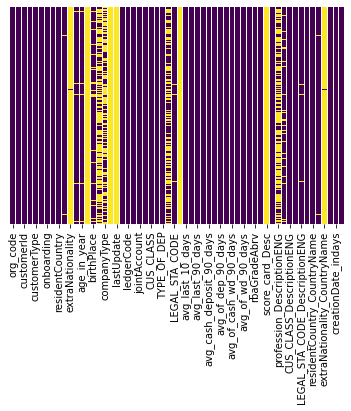

In [20]:
# https://towardsdatascience.com/using-pandas-method-chaining-to-improve-code-readability-d8517c5626ac
# df2 = df.select_dtypes(include=['object']).isnull()
df2 = df.isnull()
sns.heatmap(df2, yticklabels=False, cbar=False, cmap='viridis')

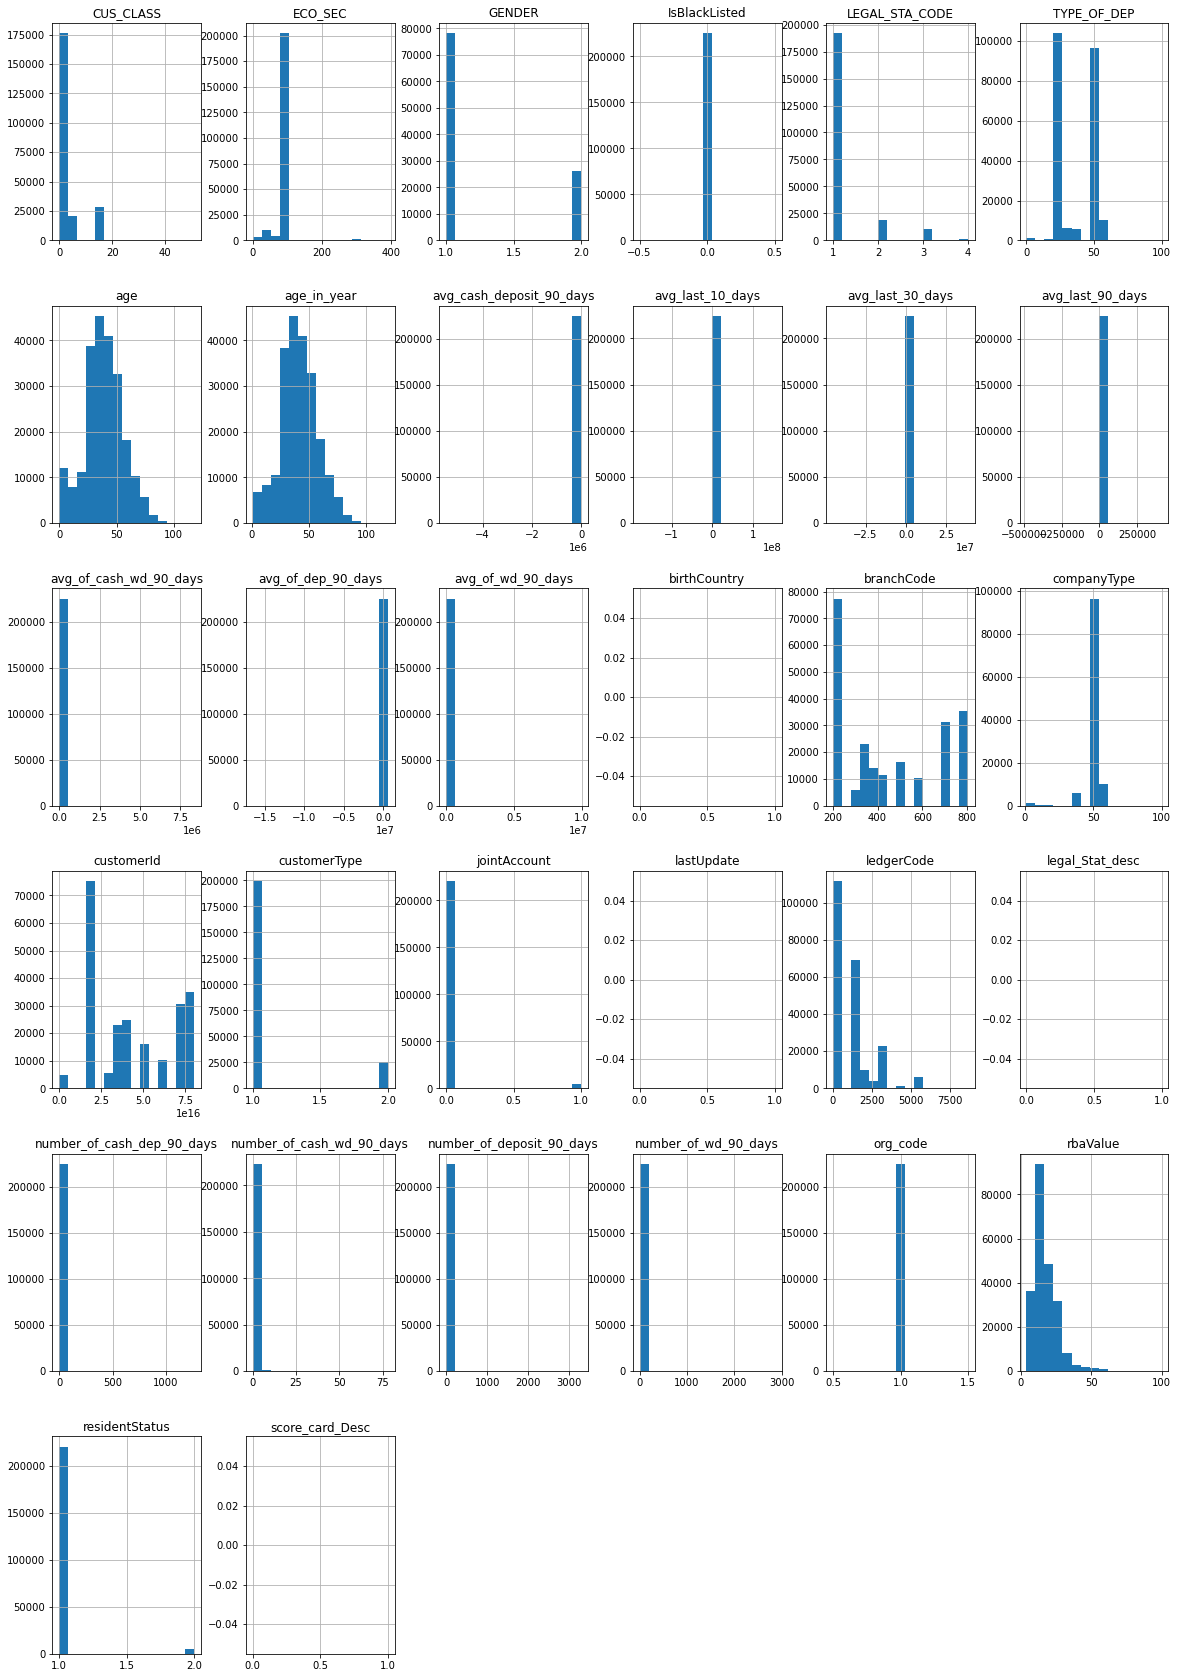

In [21]:
# Addison plot
df.select_dtypes(include=['int64', 'float64']).hist(bins=15, figsize=(20, 30), layout=(6, 6));

In [22]:
# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/#xaxis.set_visiblefalse%2fyaxis.set_visiblefalse-to-hide-axis-including-axis-label

def boxplot_manual(data):
    num_cols = 3
    num_rows = math.ceil(len(data.columns)/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols)
    fig.set_size_inches(20, 20)

    for subplot, column in enumerate(data.columns, 0):
        x, y = int(subplot / num_cols), subplot % num_cols
        axs[x, y].boxplot(data[column], vert=False)
        axs[x, y].set_title(f"Column '{column}'")
        axs[x, y].axes.yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matp

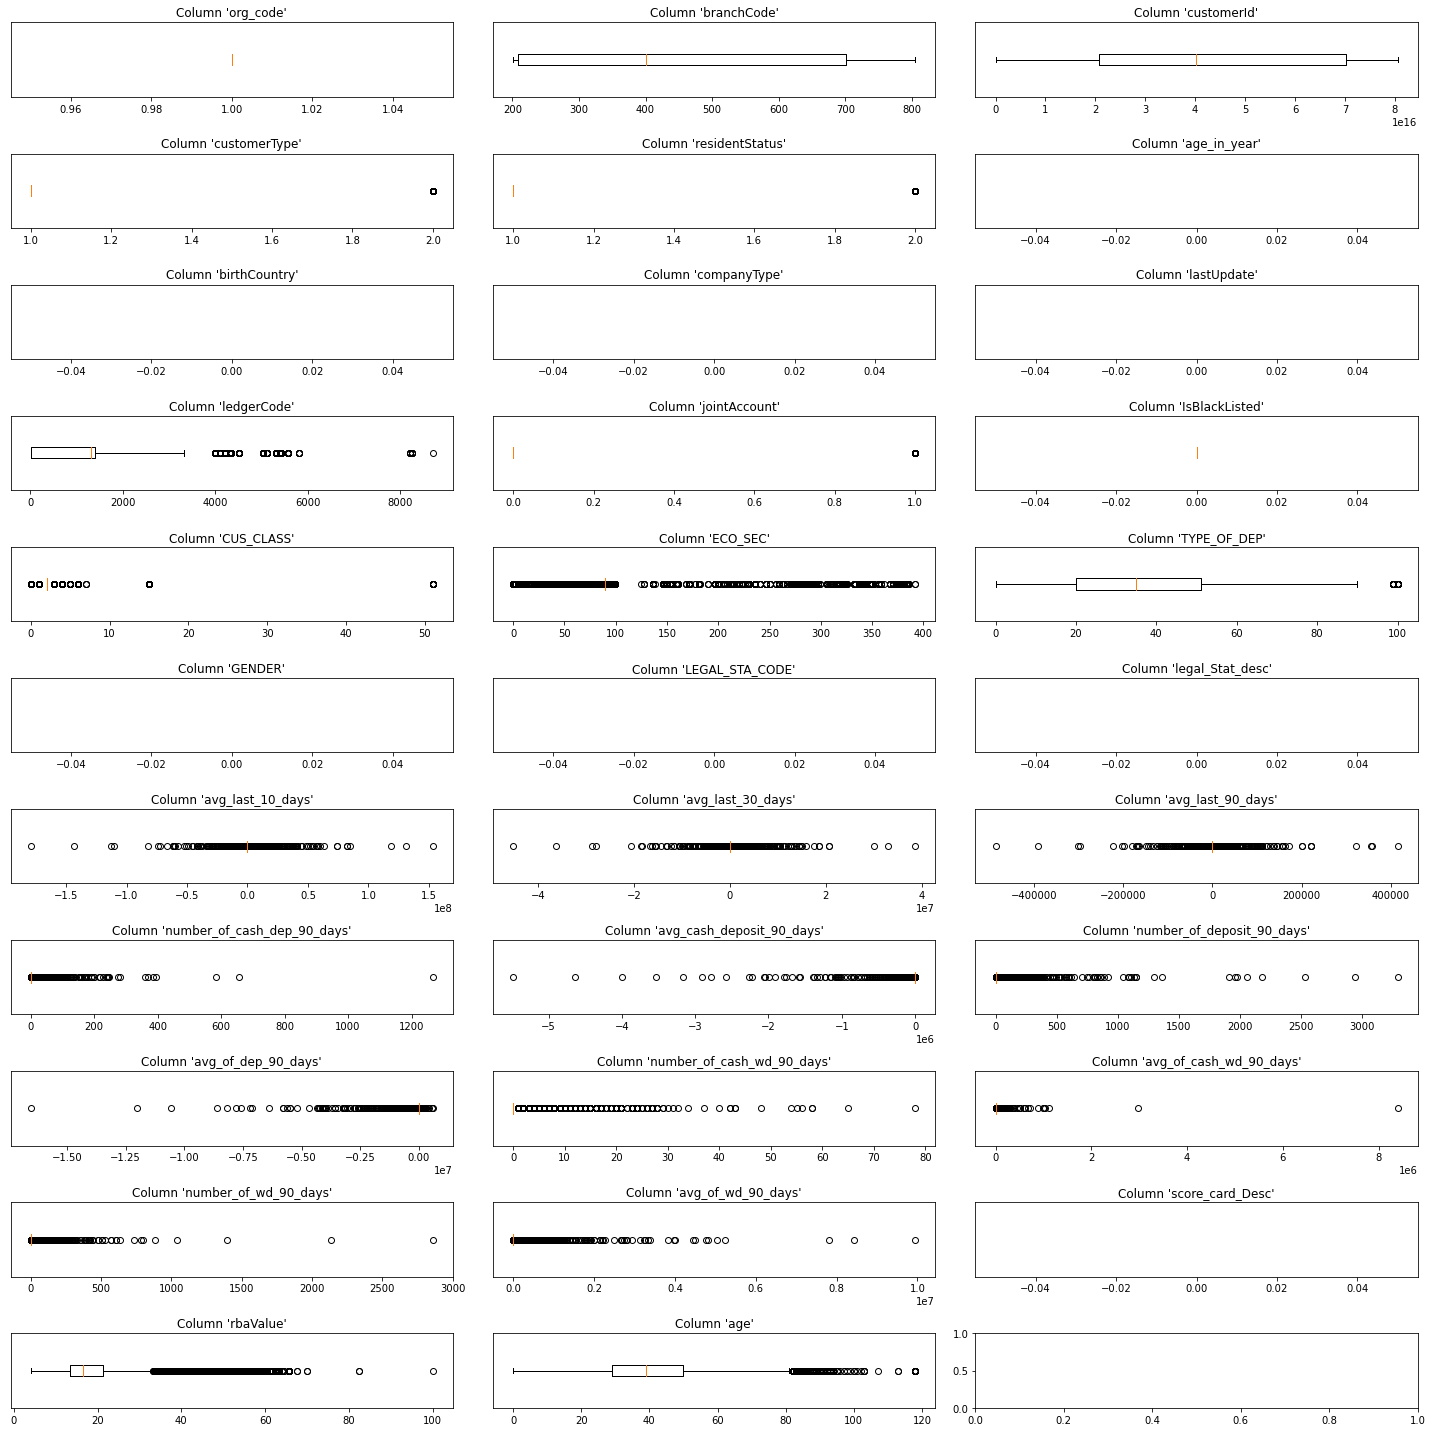

In [23]:
boxplot_manual(df.select_dtypes(include=['int64', 'float64']))

# Additional plots

Top values
* https://stackoverflow.com/questions/58272872/pandas-top-n-values-in-each-group
* https://stackoverflow.com/questions/48909110/python-pandas-mean-and-sum-groupby-on-different-columns-at-the-same-time

Using flags
* https://github.com/google/region-flags
* https://github.com/hjnilsson/country-flags
* https://pypi.org/project/emoji-country-flag/
* https://stackoverflow.com/questions/44246650/automating-bar-charts-plotting-to-show-country-flags-as-ticklabels
* https://stackoverflow.com/questions/19835746/how-to-group-remaining-results-beyond-top-n-into-others-with-pandas
* https://matplotlib.org/3.1.1/tutorials/introductory/images.html

In [24]:
def get_flag(name, width_size=20):
    """
    Downloads the country flags from GitHub of in case of failure, from a local drive.
    It resize all the images to a width defined by "width_size")
    :param name: ISO2 country name
    :type name: str
    :param width_size: Width in pixels
    :type width_size: int
    :return: Flag image
    :rtype: matplotlib.offsetbox object
    """
    try:
        path = "https://raw.githubusercontent.com/google/region-flags/gh-pages/png/{}.png".format(name)
        im = plt.imread(path)
        zoom_ = width_size/im.shape[1]
        img = OffsetImage(im, zoom=zoom_)
        # print('{}: {} then {}'.format(name, im.shape, img))
    except:  # In case the images cannot be downloaded from GitHub, gets from local drive
        path = "storage/region-flags-gh-pages-png/40x40/{}.png".format(name)
        im = plt.imread(path)
        zoom_ = width_size/im.shape[1]
        img = OffsetImage(im, zoom=zoom_)
        # print('From local drive: {} size {}'.format(name, im.shape))
    return img

def offset_image(coord, name, ax):
    """
    Place the image inside the plot passed at 'ax'.
    :param coord: Position on x (horizontal axis)
    :type coord: int
    :param name: Name of the country (ISO 2)
    :type name: str
    :param ax: subplot
    :type ax: object
    :return: Plot
    :rtype: obj
    """
    im = get_flag(name)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, 0), xybox=(0., -16.), frameon=False, xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def plot_bar_countries(df, countries, valuesA, nlargest=10):
    """
    Plots the mean of 'valuesA' per 'countries'
    :param df: DataFrame with the source of data
    :type df: pandas.DataFrame
    :param countries: Name of the column to be use to extract the countries
    :type countries: str
    :param valuesA: Name of the column to be use to extract the numeric value to average
    :type valuesA: str
    :param nlargest: Number of elements to show as columns
    :type nlargest: int
    :return: plot
    :rtype: obj
    """
    bottom_countries = df.groupby(countries).mean().sort_values(by=valuesA, ascending=False)[nlargest:].index.values
    df2 = df.replace(bottom_countries, 'Others').groupby(countries).mean().sort_values(by=valuesA, ascending=False)

    fig, ax = plt.subplots()

    ax.bar(range(len(df2.index.values)), df2[valuesA], width=0.5, align="center")
    ax.set_xticks(range(len(df2.index.values)))
    ax.set_xticklabels(df2.index.values)
    ax.tick_params(axis='x', which='major', pad=26)

    for i, c in enumerate(df2.index.values):
        offset_image(i, c, ax)

    plt.show()

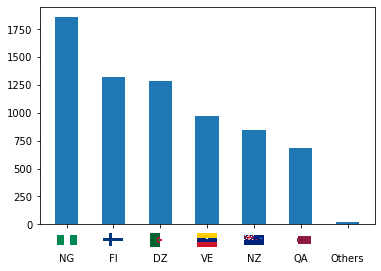

In [25]:
plot_bar_countries(df, 'residentCountry', 'avg_last_90_days', 6)

# Feature engineering

Correct the missing variants in the `birthPlace`

In [26]:
out = []
for val in df['birthPlace']:
    try:
        if val.find('?')>=0 or val.strip()=='0':
            out.append('-')
        else:
            out.append(val.strip().upper())
    except:
        out.append(val)

# pd.Series(out).value_counts()
df['birthPlace'] = out

Transformations for `onboarding` from categorical to numerical variable

In [27]:
# Addison

df["onboarding"].replace(to_replace="N", value=0, inplace=True)
df["onboarding"].replace(to_replace="Y", value=1, inplace=True)

## Remove, filtering

Some examples to be consider to be removed or filtered:<br>
More than 50% of the `GENDER` values are nulls. We remove the entire variable, or replace it with the mode (Male).<br>
Another way is to use kNN imputation with another predictive variable (Profession) as it somehow gives indictions for the gender, but it suffers from high percentage of missing values (64%).<br>
Since only 1% of the variable `LEGAL_STA_CODE` values is missing, and the dominating value is 1 (85%), it is advisable to replace the missing values with the mode. <br>
100% of the variable `legal_Stat_desc` is missing, therefore the entire variable will be removed from the dataset.<br>
No missing values at `avg_last_10_days`. The variable is a continuous number with both negative and positive values. Zero makes up 41% of total values. <br>
No missing values at `avg_last_30_days`. The variable is a continuous number with both negative and positive values. Zero makes up 42% of total values. <br>
No missing values at `avg_last_90_days`. The variable is a continuous number with both negative and positive values. Zero makes up 50% of total values. <br>
No missing values at `number_of_cash_dep_90_days`. The variable is a continuous number with positive values. Zero makes up 89% of total values. <br>
There are few notable outliers, some are suspicious such as (1267) total number of deposit within just 90 days.<br>
No missing values at `avg_cash_deposit_90_days`. The variable is a continuous number with negative values. Zero makes up 89% of total values. <br>
There are few notable outliers, but they look fine.<br>
No missing values at `number_of_deposit_90_days`. The variable is a continuous number with positive values. Zero makes up 86% of total values. 


Remove fully NA columns

In [28]:
# Drop columns where all the values are missing or null
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
df.dropna(axis='columns', how='all', inplace=True)

Remove constant value columns

In [29]:
# Addison proposal
col_unique = df.columns[df.nunique()==1]
col_unique

Index(['org_code', 'giinCode', 'status', 'IsBlackListed',
       'date_of_assessment'],
      dtype='object')

In [30]:
df.drop(col_unique, axis=1, inplace=True)

Remove high cardinality columns

In [31]:
cardinality_list = df.apply(pd.Series.nunique)/df.shape[0]*100
cardinality_list.round(1).sort_values(ascending=False)

fullaccount                        98.0
avg_last_10_days                   47.3
avg_last_30_days                   41.9
customerId                         33.5
avg_last_90_days                   16.7
dateOfBirth                         9.5
avg_of_dep_90_days                  5.0
avg_of_wd_90_days                   3.9
creationDate_indays                 3.1
creationDate                        3.1
avg_cash_deposit_90_days            2.6
avg_of_cash_wd_90_days              2.4
rbaValue                            0.3
birthPlace                          0.2
ECO_SEC_DescriptionENG              0.1
number_of_deposit_90_days           0.1
ECO_SEC                             0.1
number_of_cash_dep_90_days          0.1
ledgerCode                          0.1
number_of_wd_90_days                0.1
ledgerCode_DescriptionENG           0.1
residentCountry                     0.0
age_in_year                         0.0
accountCurrency                     0.0
residentStatus                      0.0


In [32]:
df.drop(['fullaccount'], axis=1, inplace=True)

Remove columns with high ratio of missing values
https://stackoverflow.com/a/50798593/3780957

In [33]:
na_threshold = len(df) * .80
df = df.dropna(thresh=na_threshold, axis=1)

Remove duplicate rows
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html

In [34]:
print(f'Number of duplicates {df.duplicated().sum()} rows to be removed')
df.drop_duplicates(inplace=True)

Number of duplicates 13520 rows to be removed


<ipython-input-34-17fb1494962c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


Remove unique column

In [35]:
# df.drop(['df_index'], axis=1, inplace=True)

Remove highly correlated columns

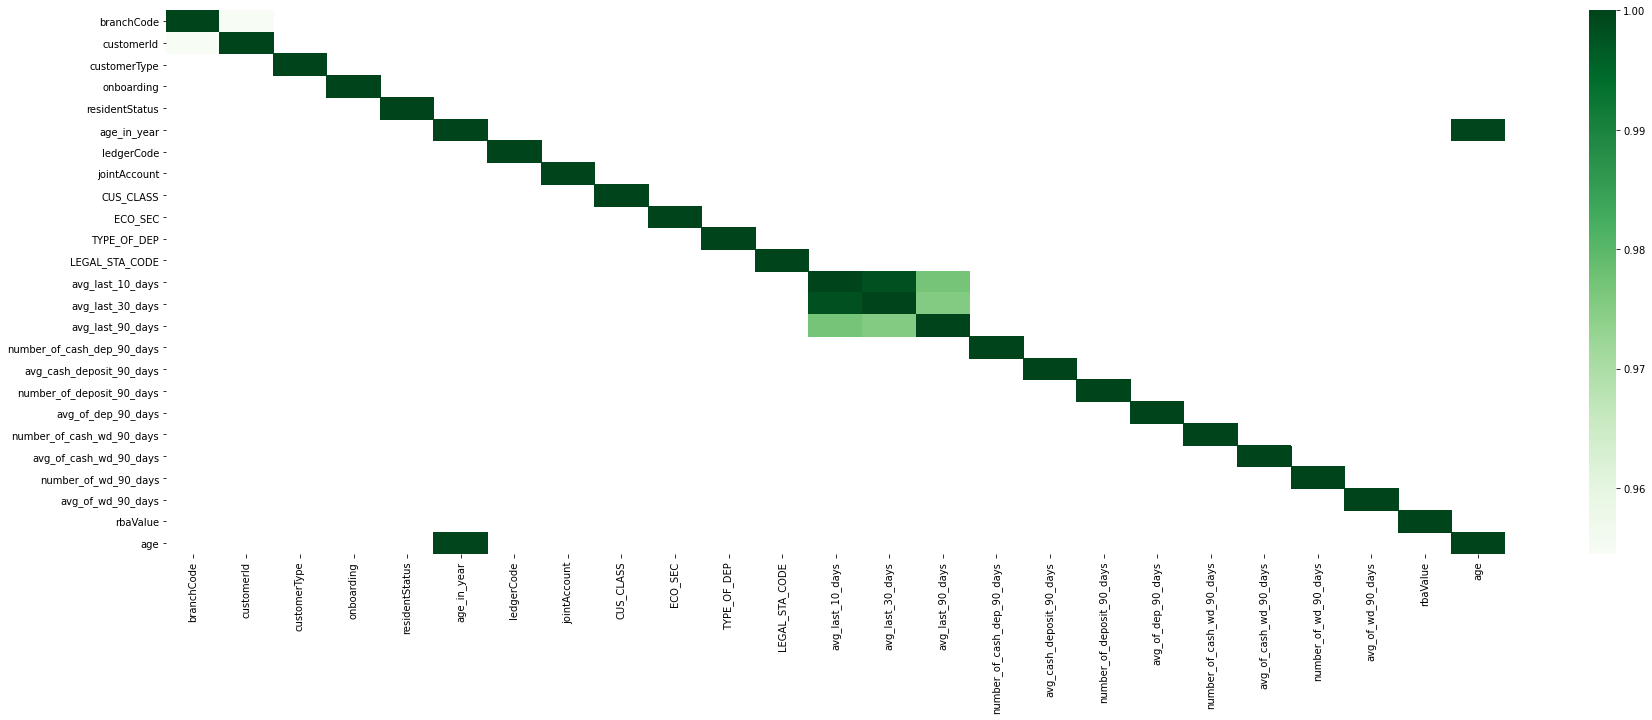

In [36]:
# https://stackoverflow.com/a/60882164/3780957

corr = df.corr()

kot = corr[corr>=.9]
plt.figure(figsize=(30,10))
sns.heatmap(kot, cmap="Greens")

In [37]:
# https://stackoverflow.com/a/63536382/3780957

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

cor_ = corrFilter(df, .8)
cor_

customerType      LEGAL_STA_CODE      0.831778
branchCode        customerId          0.954479
avg_last_30_days  avg_last_90_days    0.975413
avg_last_10_days  avg_last_90_days    0.977172
                  avg_last_30_days    0.998307
age_in_year       age                 0.999681
branchCode        branchCode               NaN
dtype: float64

In [38]:
# https://stackoverflow.com/a/25733562/3780957
df.drop(cor_.reset_index()['level_1'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Imputation

Creating variables for negative information
Meaning 1 when original variable is missing and 0 otherwise

In [39]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
num_feats = df.loc[:, num_columns]

for var in num_columns:
    if sum(1*num_feats[var].isnull()):
        print(var, 'has missings')
        mean_ = num_feats[var].mean()
        num_feats.loc[num_feats[var].isnull(), var] = mean_
        num_feats[var+'_missing'] = 1*num_feats[var].isnull()

age_in_year has missings


There are [several ways of imputing missing values](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation). I'd like to use a multivariate approach, which is much better than univariate methods (imputing by the mean, etc.). To do so, I will use the methods available in `scikit-learn` library ([here](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)).

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.

In [40]:
# num_imputer = IterativeImputer(max_iter=10, random_state=0)
# num_columns = df.select_dtypes(include=['int64', 'float64']).columns
# num_feats = num_imputer.fit_transform(df[num_columns])
# num_feats = pd.DataFrame(data=num_feats, columns=num_columns)

In [41]:
## Mode fills for missing values
cat_columns = df.select_dtypes(include=['object', 'datetime64']).columns
cat_feats = df.loc[:, cat_columns]

for var in cat_columns:
    if sum(1*cat_feats[var].isnull()):
        print(var, 'has missings')
        mode_ = cat_feats[var].mode().iloc[0]
        cat_feats.loc[cat_feats[var].isnull(), var] = mode_
        cat_feats[var+'_missing'] = 1*cat_feats[var].isna()

residentCountry has missings
nationalityOriginal has missings
dateOfBirth has missings
birthPlace has missings
ledgerCode_DescriptionENG has missings
LEGAL_STA_CODE_DescriptionENG has missings
residentCountry_CountryName has missings
nationalityOriginal_CountryName has missings


Feature engineering for the dates

In [42]:
df_time = pd.DataFrame()
for col in df.select_dtypes(include=['datetime64']):
    df_time['{}_year'.format(col)] = df[col].dt.year
    df_time['{}_month'.format(col)] = df[col].dt.month
    df_time['{}_day'.format(col)] = df[col].dt.day
    df_time['{}_dayofyear'.format(col)] = df[col].dt.dayofyear

Finally, the result of imputing both: numerical and categorical, is now merged together in a single Dataset (or you can also use a dataframe, if you prefer).

In [43]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# date_columns = df.select_dtypes(include=['datetime64']).columns
df = pd.concat([cat_feats, num_feats, df_time], axis=1, sort=False)

Dataset is ready to be analyzed. Lots of categorical and numerical variables.

In [44]:
# Drop rows with NA

df.dropna(axis='rows', how='any', inplace=True)

## Scale

Scale all the numeric values, at this point.

In [45]:
# https://stackoverflow.com/a/36475297/3780957

num_columns = df.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

# Regression model

Develop one Regression model using `rbaValue` as target variable. Remember to assess the model performance using an appropriate measure for regression.

In [46]:
y = df['rbaValue']
X = df.drop('rbaValue', axis=1)

In [47]:
X = OneHotEncoder(drop='first').fit_transform(X)

In [48]:
# https://github.com/renero/class_notebooks/blob/master/Linear%20regression.ipynb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

For Linear Regression the most important model performance metrics are <br>
R2 Score , RMSE value and Mean Absolute Percentage Error (MAPE).<br>
The closer R2 Score is to 1 the more accurate our model.<br>
RMSE value and MAPE value should be low for a good model.</h4>

In [51]:
print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Variance score (R2): {:.2f}'.format(r2_score(y_test, y_pred)))
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Mean Absolute Percentage Error: {:.2f}'.format(np.mean(np.abs((y_test - y_pred) / y_test)) * 10))

Intercept: 3.7656802165921297
Coefficients: [-1.05751469 -0.80540617  0.06697235 ...  0.07820364 -0.01192282
  0.11358193]
Mean squared error (MSE): 0.27
Variance score (R2): 0.73
Mean Absolute Error: 0.35
Root Mean Squared Error: 0.52
Mean Absolute Percentage Error: 26.40


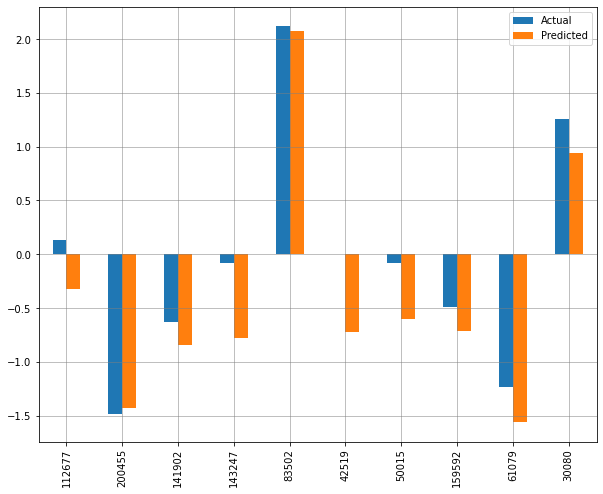

In [52]:
#Addison

result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

result1 = result[:10]
result1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Classification model

Develop one binary Classification model using `Risk_Description` setting `Risk_Description` = Low as 0 and else 1 (Medium or High). Remember to assess your model performance using a appropriate measure for classification.

In [53]:
# Merge the categories 'Medium' and 'High'
y = df['Risk_Description']
y = [0 if x=='Low' else 1 for x in y]
# pd.Series(y).value_counts()

X = df.drop('Risk_Description', axis=1)

In [54]:
X = OneHotEncoder(drop='first').fit_transform(X)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [56]:
# Metrics

accuracy = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
MCC = matthews_corrcoef(y_test, y_pred)

print('Accuracy:', accuracy)
print('F1:', F1)
print('Recall:', recall)
print('MCC:', MCC)

Accuracy: 1.0
F1: 1.0
Recall: 1.0
MCC: 1.0


In [57]:
# Calculating the confusion matrix 
# Saving confusion matrix and slice into four pieces
confusion = confusion_matrix(y_test, y_pred)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print(f"Confusion matrix:\n{confusion}")

# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[30253     0]
 [    0 11198]]

Normalized confusion matrix:
[1. 0.]
[0. 1.]


In [58]:
## Classification Accuracy
print((TP + TN) / float(TP + TN + FP + FN))
print(accuracy_score(y_test, y_pred))

1.0
1.0


In [59]:
## Classification Error
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - accuracy_score(y_test, y_pred))

0.0
0.0


In [60]:
## Sensitivity
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(recall_score(y_test, y_pred))

1.0
1.0


In [61]:
## Specificity
specificity = TN / (TN + FP)

print(specificity)

1.0


In [62]:
## False Positive Rate
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.0
0.0


In [63]:
## Precision
precision = TP / float(TP + FP)

print(precision)
print(precision_score(y_test, y_pred))

1.0
1.0


<p>The confusion matrix is a more accurate metric for model performance. We can decide whether our model is ideal or not based on which sections of the confusion matrix we want to maximize. For example, in health related predictions false positives should be minimum.</p>